# Dependencies and Packages

In [1]:
!pip install skl2onnx
!pip install onnxruntime

In [0]:
# Imports for Google Drive Authentication to get the CSV file
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics

from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier

import sklearn.cluster
import sklearn.datasets
import sklearn.metrics

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

import onnxruntime as rt

from google.colab import files

# Abstract



In this project, I explore how different supervised and unsupervised machine learning models compare when fitted on anonymous. This shows how these different models reveal the inherent structure of the data. The data is first analyzed with multiple techniques such as a correlation matrix and PCA. It is then fitted using a Decision Tree, Naive-Bayes, Random Forest, K-Means, and Agglomerative Clustering. For the data provided, a Decision makes the most sense as the model of choice. A pipeline is then created so that out-of-sample data may be tested against the model. Possibilities for research beyond the scope of this project include using different data, more advanced machine learning models, and refining the parameters of the current models.

# Overview

The purpose of this report is to find a structure or pattern in labeled anoymous data through Explorative Data Analysis. More speficially, the goal is the see how different supervised and unsupervised machine learning algorithms show these patterns and ultimately select one that will be a good model for the data so that it will accurately predict the labels on out-of-sample data.

The selection of models are as follows.


* Decision Tree (Supervised)
* Naive-Bayes (Supervised)
* Random Forest (Supervised)
* K-Means (Unsupervised)
* ~~Agglomerative (Unsupervised)~~

Agglomerative Clustering can no longer be demonstrated in this notebook due to the lack of resources provided by the Jupyter runtime. However, I can say that from previous testing, it did return results just like those of K-Means Clustering. Since Agglomerative Clustering is a Hierarchical Clustering Algorithm, and hierarchical clustering algorithms are mainly used for their skill in capturing irregular shapes in the data, I made the decision that nothing more than an explanation was needed. K-Means performed extremely well so I determined that it was unncessary to employ a more expensive algorithm.

This selection was chosen because it includes both techniques learned in class and other techniques that are important the data science community. The paper "Top 10 algorithms in data mining" provided inspiration for some these algorithms used below (Wu, et al 2007).

Both supervised and unsupervised techniques are explored here in order to take advantage of the labeled data but to also try to find natural structure in the provided data.



# Data Processing

## Authentication and CSV Retrieval

This code assumes that the CSV is located in a Google Drive drive with the specified identifier string in the variable `fileID`. A better alternative would be to host the file on Github so that it may be accessed publicly and retrieved universally. This code requires authentication for to Google Drive API to get access the the account that stores the CSV.

In the end though, it is assumed that the CSV makes its way into a Pandas DataFrame called `data`.

https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fileID = "1o8t7_LvvD5buP4NbmSAWyy83OD3fp5F4" # ID of the file to access
downloaded = drive.CreateFile({'id':fileID})
downloaded.GetContentFile('data_public.csv')

In [0]:
data = pd.read_csv('data_public.csv')

# Data Analysis

Here the features and target names are explicitly defined.

In [0]:
featureNames = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O']
targetName = 'Class'

## Basic Statistical Information

Although this is good for a quick overview of the data at-a-glance, merely describing the data does not give much insight into the structure it may have. Therefore, other tehcniques, such as computing the correlation matrix or principal components, will be more helpful.

In [7]:
data.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,-5.626123e-01,-7.432666e+00,1.069211e+01,-1.298888e+00,-1.715337e+00,-8.376662e+00,2.564679e+00,1.250097e+00,2.308441e+00,8.034096e+00,1.096927e+01,-2.569302e+00,-1.817342e+01,4.714102e+00,7.750275e+00,2.166636e+00
std,2.434552e+01,5.358689e+00,1.391955e+01,6.856531e+00,1.593805e+01,1.329916e+01,9.715908e+00,2.050294e+01,1.182328e+01,9.122371e+00,1.540449e+01,3.264653e+00,1.460082e+01,1.354750e+01,1.286000e+01,6.872945e-01
min,-3.658025e+01,-2.483024e+01,-1.329504e+01,-2.365417e+01,-2.703844e+01,-3.242560e+01,-1.782598e+01,-2.957892e+01,-1.628663e+01,-1.713628e+01,-1.550703e+01,-1.538548e+01,-3.959267e+01,-1.807380e+01,-1.410457e+01,1.000000e+00
25%,-2.190966e+01,-1.199548e+01,3.122246e-01,-5.221629e+00,-1.717748e+01,-1.847365e+01,-5.018479e+00,-1.814894e+01,-8.798066e+00,4.663393e+00,-3.789138e+00,-4.815882e+00,-3.253720e+01,-8.564706e+00,-4.916820e+00,2.000000e+00
50%,-6.043285e+00,-6.841852e+00,2.903836e+00,-2.683514e+00,1.938928e+00,-1.526870e+01,-1.500786e+00,1.556922e+00,1.570005e+00,8.908198e+00,1.042090e+01,-2.917836e+00,-1.345052e+01,7.400789e+00,1.184960e+01,2.000000e+00
75%,3.030517e+01,-3.649784e+00,2.778294e+01,4.777707e+00,1.581311e+01,7.629761e+00,1.298093e+01,2.473866e+01,1.152911e+01,1.475206e+01,2.639554e+01,-6.125631e-01,-4.138239e+00,1.794834e+01,2.048135e+01,3.000000e+00
max,4.609603e+01,1.506701e+01,4.475665e+01,1.402662e+01,2.707671e+01,2.489338e+01,3.268256e+01,4.075752e+01,3.083255e+01,3.400029e+01,4.772271e+01,1.223828e+01,1.163477e+01,3.286069e+01,3.183829e+01,3.000000e+00


## Correlation Matrix

In this step, the data is copied over to a separate DataFrame for which a correlation matrix is constructed. This is used to find which features may be highly correlated with others. It is important to identify these because it may interfere with the performace of some alorithms. However, they do not necessarily have to be removed. Some algorithms, such as decision trees and k-means operate just as well.

https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

In [8]:
removed = data

# Create correlation matrix
corr_matrix = removed.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

# Drop features 
removed = removed.drop(removed[to_drop], axis=1)

['F', 'H', 'K', 'M', 'N', 'O']


Uncomment and run this code if the highly correlated features should be removed and use the *keptFeatures* list instead of `featureNames`

In [0]:
#data = removed
# Run this code if some features were removed in the last step
#keptFeatures = []
#for i in featureNames:
#  if i not in to_drop:
#    keptFeatures.append(i)
#featureNames = keptFeatures

## Normalization

In this step, the data is normalized so that any irregularies between the features are eliminated so that not any single one can negatively affect the performance of any of the models.

Note that all of the values are present in the data so it is not necessary to perform any imputation, but if there was then it should be performed in the step before the normalization.

In [0]:
X = StandardScaler().fit_transform(data[featureNames]) # standardize the data
X = pd.DataFrame(X)
y = data[targetName]

## Principal Component Analysis

Calculate and print the  percentage of variance explained by each feature before performing PCA. Notice here that the features are coming from the `data` DataFrame, which contains the data *before* it was normalized.

In [11]:
# calculate variances for each feature before perfoming PCA
variances = []
for f in featureNames:
  variances.append(data[[f]].var()[0])
# calculate the total variance
totalVar = sum(variances)
# print out the variance ratio for each feature
for f,v in zip(featureNames, variances):
  print('Percent of variance from {} ='.format(f), v/totalVar)

Percent of variance from A = 0.2086320285911894
Percent of variance from B = 0.010107882196086571
Percent of variance from C = 0.06820143910476024
Percent of variance from D = 0.016548241838629775
Percent of variance from E = 0.08941560411215943
Percent of variance from F = 0.062257507735134186
Percent of variance from G = 0.03322843013786593
Percent of variance from H = 0.14797062782656153
Percent of variance from I = 0.049206142235367664
Percent of variance from J = 0.029292639554512518
Percent of variance from K = 0.08352908740273693
Percent of variance from L = 0.0037516049608718707
Percent of variance from M = 0.07504077299938758
Percent of variance from N = 0.0646043267353379
Percent of variance from O = 0.05821366456939837


Perform Principal Component Analysis on the data and print out how much of the variance is explained by each of the new Principal Components.

In [12]:
pca = PCA() # get a pca object
principalComponents = pca.fit_transform(X) # perform the pca

# Put the new principle components into a pandas dataframe
principalDf = pd.DataFrame(data = principalComponents, columns = ['C'+str(x) for x in range(len(featureNames))])

print('Variance Ratios after PCA:')
for c,p in zip(principalDf.columns,pca.explained_variance_ratio_):
  print(c, ':', p)

Variance Ratios after PCA:
C0 : 0.7234810354589722
C1 : 0.201449639896675
C2 : 0.03286286285231795
C3 : 0.011965365878107167
C4 : 0.006377877959189069
C5 : 0.005072002448780686
C6 : 0.0039053729843848196
C7 : 0.0031694732820784733
C8 : 0.0025566221201425
C9 : 0.0023475877286556024
C10 : 0.0018596036239526814
C11 : 0.0015841841267998445
C12 : 0.001398750058046944
C13 : 0.001038715210166398
C14 : 0.0009309063717306663


A simple plot of the top two principal Components. Notice that the data is situated into three well-separated, homogenous clusters, each of which corresponds to one of the three classes that all of the data points are assigned.

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

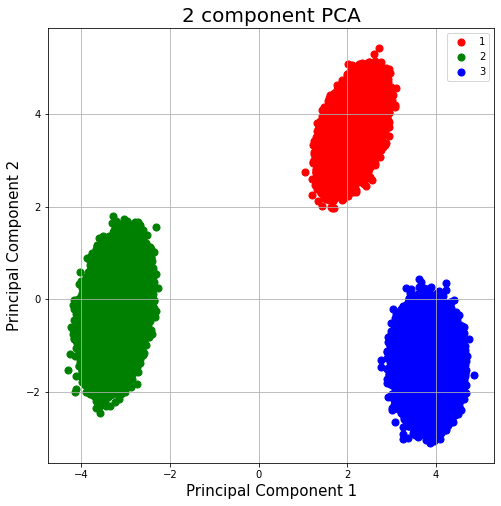

In [13]:
finalDf = pd.concat([principalDf[['C0', 'C1']], data[['Class']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 2, 3]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'C0']
               , finalDf.loc[indicesToKeep, 'C1']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Model Training and Validation

## Train-Test Split

Before trying the various models, the data should be split into training and testing sets. As usual, this will be an 80/20 split.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
trainingData = pd.concat([X_train, y_train], axis=1)

## SciKit-Learn DecisionTreeClassifier (Optimized CART)

Optimized CART is the Decision Tree Algorithm that is used by Sci-Kit Learn. This is one of the simplest models for machine learning, but it is also one of the most powerful and flexible. Notice that on the provided data, it works extremely well, even though it is allowed to run to completion without any pruning whatsoever.

After testing, notice that the Precision, Recall, and F1-Scores are strong for all targets. This verifies that the model is a good one.

In [15]:
dtc = tree.DecisionTreeClassifier().fit(X_train, y_train)
dtc_predicted = dtc.predict(X_test)
expected = y_test
print(metrics.classification_report(expected, dtc_predicted))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     39812
           2       1.00      1.00      1.00    120150
           3       1.00      1.00      1.00     80038

    accuracy                           1.00    240000
   macro avg       1.00      1.00      1.00    240000
weighted avg       1.00      1.00      1.00    240000



Here is a simple plot of the Decision Tree generated by the code above. Notice that it only needed to make a few splits in order for every leaf of the tree to be pure. This is consistent with the plot of the Principal Components from the Data Analysis section above.

[Text(267.84000000000003, 271.8, 'X[12] <= -0.162\ngini = 0.611\nsamples = 960000\nvalue = [160291, 479681, 320028]'),
 Text(133.92000000000002, 163.08, 'gini = 0.0\nsamples = 479681\nvalue = [0, 479681, 0]'),
 Text(401.76000000000005, 163.08, 'X[0] <= 0.515\ngini = 0.445\nsamples = 480319\nvalue = [160291, 0, 320028]'),
 Text(267.84000000000003, 54.360000000000014, 'gini = 0.0\nsamples = 160291\nvalue = [160291, 0, 0]'),
 Text(535.6800000000001, 54.360000000000014, 'gini = 0.0\nsamples = 320028\nvalue = [0, 0, 320028]')]

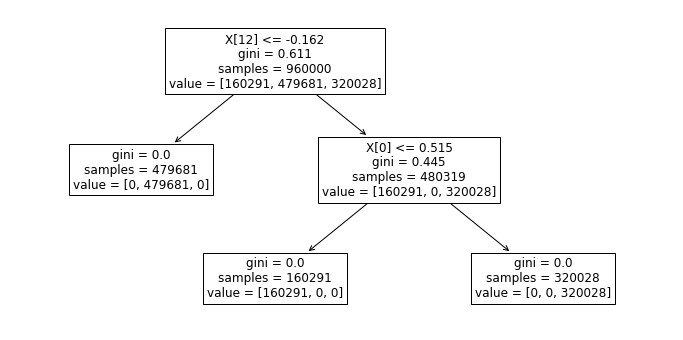

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
tree.plot_tree(dtc, fontsize=12, ax=ax)

## Gaussian Naive-Bayes

Naive-Bayes is another extremely common classification model, but unlike Decision Trees, this one is a *probabilistic* classification algorithm that is based on Bayes Theorem. Notice that this also has extremely good Precision, Recall, and F1-Scores, meaning that this is also a good model.

In [17]:
nb = GaussianNB().fit(X_train, y_train)
nb_predicted = nb.predict(X_test)
expected = y_test
print(metrics.classification_report(expected, nb_predicted))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     39812
           2       1.00      1.00      1.00    120150
           3       1.00      1.00      1.00     80038

    accuracy                           1.00    240000
   macro avg       1.00      1.00      1.00    240000
weighted avg       1.00      1.00      1.00    240000



## Random Forest

The Random Forest Classifier is an extension of the idea of a Decision Tree. But instead  of simply growing a tree by looking for the optimal split, it fits many decision trees onto subsets of the sample on which the algorithm is run. This is to ensure that the data is not overfit. But also we observed earlier, a classic decision tree had no issues with overfitting for our particular set of data. Therefore, looking at the metrics for Random Forest, it performs just as well as the decision tree.

In [18]:
rfc = RandomForestClassifier().fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
expected = y_test
print(metrics.classification_report(expected, rfc_predicted))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     39812
           2       1.00      1.00      1.00    120150
           3       1.00      1.00      1.00     80038

    accuracy                           1.00    240000
   macro avg       1.00      1.00      1.00    240000
weighted avg       1.00      1.00      1.00    240000



## K-Means Clustering

K-Means is the most basic of all clustering algorithms, which are a type of algorithm used to perform unsupervised learning on the data. Even though the data provided contrains class labels, an unsupervised method is still important because it highlights natural structures and patterns in the data without the information for why those structures exist.

Once again looking back at the plot of the Principal Components above, notice that the data is naturally organized into very dense clusters that correspond to the classes given, so K-Means may be the best model because it finds the natural structure of the data.

In [19]:
kmeans = sklearn.cluster.KMeans(3).fit(X)
print('Homogeneity: ', sklearn.metrics.homogeneity_score(y, kmeans.labels_))
print('Completeness: ', sklearn.metrics.completeness_score(y, kmeans.labels_))

Homogeneity:  1.0
Completeness:  1.0


## Agglomerative Clustering

Agglomerative Clustering is a hierarchical clustering algorithm that is very useful for finding non-blob-shaped clusters in the data. Note that the code below may cause Jupyter to crash due to excessive memory usage, but on previous iterations it has been shown to perform just as well as K-Means because of the nature of our set of data.

In [0]:
#agg = sklearn.cluster.AgglomerativeClustering(3).fit(X)
#print('Homogeneity: ', sklearn.metrics.homogeneity_score(y, agg.labels_))
#print('Completeness: ', sklearn.metrics.completeness_score(y, agg.labels_))

# Pipeline

## Description

After trying a range of models on which to fit the data, one can conclude that there are multiple models that will suffice. For the pipeline, I have chosen the classifier to be a Decision Tree. Firstly because it is the simplest model that performs well. It quickly indentifies the natural structure of the data while also taking advantage of the labels that are provided.

The pipeline starts with a standard scalar just as above in order to make sure that the data is of the location and range. Then a default DecisionTreeClassifier is used just like the one above, which was sufficient to achieve the metrics like the one above.

## Create Pipeline

Inspired by the code in the *ONNX Example* Notebook.

In [0]:
preprocessor = Pipeline(steps = [
  ('scaler', StandardScaler())
])

classifier = Pipeline(steps = [
  ('dtc', tree.DecisionTreeClassifier())
])

pipeline = Pipeline(steps = [
  ('preprocessor', preprocessor),
  ('classifier', classifier)
])

Test the pipeline with the original data train/test split. Notice that the results are the same as those ealier, meaning that the pipeline works as expected and is ready to be exported.

In [22]:
pipeline.fit(X_train, y_train)
predictedFromPipeline = pipeline.predict(X_test)
expectedFromPipeline = y_test
print(metrics.classification_report(expectedFromPipeline, predictedFromPipeline))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     39812
           2       1.00      1.00      1.00    120150
           3       1.00      1.00      1.00     80038

    accuracy                           1.00    240000
   macro avg       1.00      1.00      1.00    240000
weighted avg       1.00      1.00      1.00    240000



Export the pipeline.

In [0]:
input_types = dict([(x, FloatTensorType([None, 1])) for x in featureNames])

try:
    model_onnx = convert_sklearn(pipeline,
                                 'pipeline_onnx',
                                initial_types=list(input_types.items()))
except Exception as e:
    print(e)

with open("project_pipeline.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())



Test the pipeline.

In [24]:
inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in 
               X_test.rename(columns = {h:i for h,i in zip(range(15), featureNames)})
               .to_dict(orient='list')
               .items()}

session_onnx = rt.InferenceSession("project_pipeline.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)
print("predict", predict_onnx[0])

print(metrics.classification_report(y_test, predict_onnx[0]))

predict [2 2 3 ... 1 2 1]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     39812
           2       1.00      1.00      1.00    120150
           3       1.00      1.00      1.00     80038

    accuracy                           1.00    240000
   macro avg       1.00      1.00      1.00    240000
weighted avg       1.00      1.00      1.00    240000



In [0]:
files.download('project_pipeline.onnx')

# Conclusion

After fitting on multiple models, I determine that the data is situated in dense, well-separated clusters that are best found using a decision tree. The results from the preliminary data analysis, plus the testing results from each of the models, all provide resounding support that this is the best model to use. I determine this because of the natural flexibility that a decision tree provides, so that it is unlikely that new data will dramatically change the performace of the model.

# Biblograph and Sources

The sources of code that have been referenced above will be repeated here.

Code Snippets
* https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/
* https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
* https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
* ONNX Example Notebook (Provided to the class by professor)

Data
* The Data (Provided to the class by professor)

Academic Inpirations and References
* M. R. Sumalatha, M. Ananthi, A. Arvind, N. Navin and C. Siddarth, "Highly correlated feature set selection for data clustering," 2014 International Conference on Recent Trends in Information Technology, Chennai, 2014, pp. 1-4.
* Zhao Lu, Haoda Fu, Gangbing Song. (2015) A multi-scale non-parametric and parametric hybrid multi-category recognition algorithm with probabilistic outputs. Journal of Experimental & Theoretical Artificial Intelligence 27:4, pages 487-500. 
* Wu, X., Kumar, V., Ross Quinlan, J. et al. Top 10 algorithms in data mining. Knowl Inf Syst 14, 1–37 (2008). https://doi.org/10.1007/s10115-007-0114-2